In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
from sklearn.preprocessing import minmax_scale
from scipy.signal import resample
import heartpy as hp
import warnings
warnings.filterwarnings('ignore')

In [3]:
source_dir = 'D:/Dropbox/raw_signals_org/'

rawdata_list = os.listdir(source_dir)
print(len(rawdata_list))

1285


In [4]:
def get_difference_list(seq):
    seq  = np.concatenate([[0], seq, [0]])
    differ = seq[1:] - seq[:-1]
    differ = differ[1:-1]
    return differ

In [4]:
def check_abp(abp, sig_length=125*15, fs=125):
    
    ABP = minmax_scale(abp)
    # Transpose the Signals if they are in column format, necessary for peak detection
    if ABP.shape[0] > 1:
        ABP = ABP.T

    try:
        wd_a, _ = hp.process(ABP, sample_rate=fs) # peak detection
    except Exception:
        return {'result': 1, 'reason': 'heartpy 사용중 error'}
    
    # Peak
    pks_ABP = wd_a['peaklist'] # peak location list
    pks_ABP = np.array(pks_ABP)

    # Valley
    P2PIDX =  np.concatenate([pks_ABP[:-1][..., np.newaxis], pks_ABP[1:][..., np.newaxis] ], axis=-1)
    val_ABP =  np.unique([np.argmin(ABP[i[0]:i[1]]) +i[0]  for i in P2PIDX])

    if pks_ABP[-1] == (sig_length-1):
        pks_ABP = np.delete(pks_ABP,-1)

    # Peak
    peak_dist_ABP = get_difference_list(pks_ABP) # Interval between peaks
    std_peak_dist_ABP = np.std(peak_dist_ABP)    # feature 1
    std_peaks_ABP = np.std(ABP[pks_ABP])         # feature 2
    max_min_differ_pks = np.max(ABP[pks_ABP]) - np.min(ABP[pks_ABP]) # feature 3
    differ_pks = get_difference_list(ABP[pks_ABP])
    max_differ_pks = max(np.abs(differ_pks))     # feature 4
    
    # Bad signal detection through peak
    if (std_peaks_ABP > 0.12):
        return {'result': 1, 'reason': 'peak들의 std가 0.12 초과'}
    if (std_peak_dist_ABP > 12):
        return {'result': 1, 'reason': 'peak간격의 std가 12 초과'}
    if (max_min_differ_pks > 0.28):
        return {'result': 1, 'reason': '최대 peak와 최소 peak 차이가 0.28 초과'}
    if (max_differ_pks > 0.19):
        return {'result': 1, 'reason': 'peak간 차분값의 최댓값이 0.19 초과'}
    

    # If the first peak is detected too late or the last peak is detected too early => bad signal
    if (pks_ABP[0] > 2*np.mean(peak_dist_ABP)) or (sig_length - pks_ABP[-1] > 2*np.mean(peak_dist_ABP)):
        return {'result': 1, 'reason': '첫번째 peak가 너무 늦게 검출되거나, 마지막 peak가 너무 이르게 검출됌'}

    # valley
    valley_dist_ABP = get_difference_list(val_ABP) # Interval between valleys
    std_valley_dist_ABP = np.std(valley_dist_ABP)  # feature 5
    std_valley_ABP = np.std(ABP[val_ABP])          # feature 6
    max_min_differ_val = np.max(ABP[val_ABP]) - np.min(ABP[val_ABP]) # feature 7
    differ_val = get_difference_list(ABP[val_ABP])
    max_differ_val = max(np.abs(differ_val))       # feature 8

    # Bad signal detection through valley
    if (std_valley_ABP > 0.12):
        return {'result': 1, 'reason': 'valley들의 std가 0.12 초과'}
    if (std_valley_dist_ABP > 26):
        return {'result': 1, 'reason': 'valley간격의 std가 26 초과'}
    if (max_min_differ_val > 0.28):
        return {'result': 1, 'reason': '최대 valley와 최소 valley 차이가 0.28 초과'}
    if (max_differ_val > 0.19):
        return {'result': 1, 'reason': 'valley간 차분값의 최댓값이 0.19 초과'}
    
    return {'result': 0, 'reason': '정상'}

In [5]:
def check_ppg_normal(ppg, sig_length, fs=125):
    if np.mean(ppg)>=1:
        ppg = ppg/4

    PPG = minmax_scale(ppg)
    # Transpose the Signals if they are in column format, necessary for peak detection
    if PPG.shape[0] > 1:
        PPG = PPG.T

    try:
        wd_p, _ = hp.process(PPG, sample_rate=fs) # peak detection
    except Exception:
        return {'result': 1, 'reason': 'heartpy 사용중 error'}

    # Peak
    pks_PPG = wd_p['peaklist'] # peak location list
    pks_PPG = np.array(pks_PPG)

    # Valley
    P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
    val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])  

    if all(np.gradient(PPG[-3:])>=0):
        val_PPG = np.concatenate([val_PPG, [np.argmin(PPG[pks_PPG[-1]:len(PPG)])+pks_PPG[-1]]], axis=-1)

    if pks_PPG[-1] == (sig_length-1):
        pks_PPG = np.delete(pks_PPG,-1)

    peak_dist_PPG = get_difference_list(pks_PPG) # Interval between peaks
    std_peak_dist_PPG = np.std(peak_dist_PPG)    # feature 1
    std_peaks_PPG = np.std(PPG[pks_PPG])         # feature 2
    max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # feature 3
    differ_pks = get_difference_list(PPG[pks_PPG])
    max_differ_pks = max(np.abs(differ_pks))     # feature 4


    # Bad signal detection through peak
    if (std_peaks_PPG > 0.14):
        return {'result': 1, 'reason': 'peak들의 std가 0.14 초과'}
    if (std_peak_dist_PPG > 14):
        return {'result': 1, 'reason': 'peak간격의 std가 14 초과'}
    if (max_min_differ_pks > 0.38):
        return {'result': 1, 'reason': '최대 peak와 최소 peak 차이가 0.38 초과'}
    if (max_differ_pks > 0.22):
        return {'result': 1, 'reason': 'peak간 차분값의 최댓값이 0.22 초과'}

    # If the first peak is detected too late or the last peak is detected too early => bad signal
    if (pks_PPG[0] > 2*np.mean(peak_dist_PPG)) or (sig_length - pks_PPG[-1] > 2*np.mean(peak_dist_PPG)):
        return {'result': 1, 'reason': '첫번째 peak가 너무 늦게 검출되거나, 마지막 peak가 너무 이르게 검출됌'}


    # valley
    valley_dist_PPG = get_difference_list(val_PPG) # Interval between valleys
    std_valley_dist_PPG = np.std(valley_dist_PPG)  # feature 5
    std_valley_PPG = np.std(PPG[val_PPG])          # feature 6
    max_min_differ_val = np.max(PPG[val_PPG]) - np.min(PPG[val_PPG]) # feature 7
    differ_val = get_difference_list(PPG[val_PPG])
    max_differ_val = max(np.abs(differ_val))       # feature 8

    # Bad signal detection through valley
    if (std_valley_PPG > 0.14):
        return {'result': 1, 'reason': 'valley들의 std가 0.14 초과'}
    if (std_valley_dist_PPG > 25):
        return {'result': 1, 'reason': 'valley간격의 std가 25 초과'}
    if (max_min_differ_val > 0.38):
        return {'result': 1, 'reason': '최대 valley와 최소 valley 차이가 0.38 초과'}
    if (max_differ_val > 0.22):
        return {'result': 1, 'reason': 'valley간 차분값의 최댓값이 0.22 초과'}

    return {'result': 0, 'reason': '정상'}

In [26]:
def check_ppg_abnormal(ppg, sig_length, fs):
    if np.mean(ppg)>=1:
        ppg = ppg/4

    PPG = minmax_scale(ppg)
    # Transpose the Signals if they are in column format, necessary for peak detection
    if PPG.shape[0] > 1:
        PPG = PPG.T

    try:
        wd_p, _ = hp.process(PPG, sample_rate=fs) # peak detection
    except Exception:
        return {'result': 1, 'reason': 'heartpy 사용중 error'}

    # Peak
    pks_PPG = wd_p['peaklist'] # peak location list
    pks_PPG = np.array(pks_PPG)

    if pks_PPG[-1] == (sig_length-1):
        pks_PPG = np.delete(pks_PPG,-1)

    # Valley
    P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
    val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])  

    if all(np.gradient(PPG[-3:])>=0):
        val_PPG = np.concatenate([val_PPG, [np.argmin(PPG[pks_PPG[-1]:len(PPG)])+pks_PPG[-1]]], axis=-1)

    # peak
    peak_dist_PPG = get_difference_list(pks_PPG) # Interval between peaks
    std_peak_dist_PPG = np.std(peak_dist_PPG)    # feature 1
    std_peaks_PPG = np.std(PPG[pks_PPG])         # feature 2
    max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # feature 3
    differ_pks = get_difference_list(PPG[pks_PPG])
    max_differ_pks = max(np.abs(differ_pks))     # feature 4


    # Bad signal detection through peak
    if (std_peaks_PPG > 0.14):
        return {'result': 1, 'reason': 'peak들의 std가 0.14 초과'}
    if (std_peak_dist_PPG > 14):
        return {'result': 1, 'reason': 'peak간격의 std가 14 초과'}
    if (max_min_differ_pks > 0.4):
        return {'result': 1, 'reason': '최대 peak와 최소 peak 차이가 0.4 초과'}
    if (max_differ_pks > 0.3):
        return {'result': 1, 'reason': 'peak간 차분값의 최댓값이 0.3 초과'}

    # If the first peak is detected too late or the last peak is detected too early => bad signal
    if (pks_PPG[0] > 3*np.mean(peak_dist_PPG)) or (sig_length - pks_PPG[-1] > 3*np.mean(peak_dist_PPG)):
        return {'result': 1, 'reason': '첫번째 peak가 너무 늦게 검출되거나, 마지막 peak가 너무 이르게 검출됌'}


    # valley
    valley_dist_PPG = get_difference_list(val_PPG)  # Interval between valleys
    std_valley_dist_PPG = np.std(valley_dist_PPG)   # feature 5
    max_min_differ_val = np.max(PPG[val_PPG]) - np.min(PPG[val_PPG]) # feature 6
    differ_val = get_difference_list(PPG[val_PPG])
    max_differ_val = max(np.abs(differ_val))        # feature 7

    # Bad signal detection through valley
    if (std_valley_dist_PPG > 38):
        return {'result': 1, 'reason': 'valley간격의 std가 38 초과'}
    if (max_min_differ_val > 0.4):
        return {'result': 1, 'reason': '최대 valley와 최소 valley 차이가 0.4 초과'}
    if (max_differ_val > 0.3):
        return {'result': 1, 'reason': 'valley간 차분값의 최댓값이 0.3 초과'}

    return {'result': 0, 'reason': '정상'}

In [6]:
source_dir = 'D:/Dropbox/raw_signals_org/'
output_dir = 'D:/Dropbox/val/'

time_len = 25

fs0 = 125 # Before sampling rate
fs1 = 100 # After sampling rate
intv = fs0 * time_len # segment length / (sampling rate)*(seconds)

In [308]:
file_num = len(rawdata_list)
total_data_num = 0

for idx, p in enumerate(rawdata_list):   # range(len(rawdata_list)):

    wf_dic = dict()
    wf_dic['ART'] = list()
    wf_dic['PLETH'] = list()
    data_num = 0 

    data = np.load(source_dir + p, allow_pickle=True) # raw_signal_load
    rec_nb = len(data['record_name']) # number of records for one patient
    print(f'checking ({idx+1}/{file_num})th file, rec_num: {rec_nb}')

    for i in range(rec_nb):
        L = data['sig_len'][i]  # signal length of a record
        if L <= 1875:
            continue
        L=L-1875
        print(f'({idx+1}/{file_num})file-({i+1}/{rec_nb})rec. rec_len: {L}')
        abp0 = data['ART'][i]   # whole ART in a record
        ppg0 = data['PLETH'][i] # whole PPG in a record

        for j in range(0, L//intv):   
            start = intv*j
            end   = intv*(j+1)
            t1    = intv*(j+1) + 937
            t2    = intv*(j+1) + 1875

            ppgf0 = ppg0[start:end]
            ppgf1 = ppg0[end:t1]
            ppgf2 = ppg0[t1:t2]
            abpf = abp0[end:t2]
            
            # NA -> continue
            if (np.sum(np.isnan(abpf)) > 0):
                continue
            if (np.sum(np.isnan(ppgf0)) > 0) or (np.sum(np.isnan(ppgf1)) > 0) or (np.sum(np.isnan(ppgf2)) > 0):
                continue

            # Limit ABP to a range of 30 to 220 and limit PPG to a positive number.
            if (np.min(abpf) < 20) or (np.max(abpf) > 220):
                continue
            if (np.min(ppgf0) < 0) or (np.min(ppgf1) < 0) or (np.min(ppgf2) < 0):
                continue

            # bad signal decision
            if check_ppg_normal(ppgf0, sig_length=125*25)['result'] == 1:
                continue
            if check_ppg_abnormal(ppgf1, sig_length=937, fs=125)['result'] == 0 and check_ppg_abnormal(ppgf2, sig_length=937, fs=125)['result'] == 0:
                continue
            if check_abp(abpf)['result']==1:
                continue
            
            ppg = ppg0[start:t2]
            if np.mean(ppg)>=1:
                ppg = ppg/4

            resample_ppg = np.array(resample(ppg, fs1*time_len))
            if check_ppg_abnormal(resample_ppg[2500:3250], sig_length=750, fs=100)['result'] == 0 and check_ppg_abnormal(resample_ppg[3250:], sig_length=750, fs=100)['result'] == 0:
                continue

            wf_dic['ART'].append(np.array(resample(abp0[start:t2], fs1*time_len)))
            wf_dic['PLETH'].append(np.array(resample_ppg))
            data_num+=1

    if len(wf_dic['PLETH']) != 0:
        np.savez_compressed(output_dir + 'valSet' + str(idx+1), **wf_dic)
    total_data_num+=data_num
    print(f'{data_num} data from {idx+1}th file. total data: {total_data_num}')
    del wf_dic

checking (1/1285)th file, rec_num: 5
(1/1285)file-(1/5)rec. rec_len: 1500
(1/1285)file-(2/5)rec. rec_len: 18125
(1/1285)file-(3/5)rec. rec_len: 1124125
(1/1285)file-(4/5)rec. rec_len: 2798625
(1/1285)file-(5/5)rec. rec_len: 350375
12 data from 1th file. total data: 12
checking (2/1285)th file, rec_num: 9
(2/1285)file-(1/9)rec. rec_len: 17500
(2/1285)file-(2/9)rec. rec_len: 12500
(2/1285)file-(3/9)rec. rec_len: 208750
(2/1285)file-(4/9)rec. rec_len: 207375
(2/1285)file-(5/9)rec. rec_len: 102375
(2/1285)file-(6/9)rec. rec_len: 6250
(2/1285)file-(7/9)rec. rec_len: 4750
(2/1285)file-(8/9)rec. rec_len: 1241125
(2/1285)file-(9/9)rec. rec_len: 1491375
0 data from 2th file. total data: 12
checking (3/1285)th file, rec_num: 1
(3/1285)file-(1/1)rec. rec_len: 8750
0 data from 3th file. total data: 12
checking (4/1285)th file, rec_num: 28
(4/1285)file-(1/28)rec. rec_len: 185875
(4/1285)file-(2/28)rec. rec_len: 991375
(4/1285)file-(3/28)rec. rec_len: 1028500
(4/1285)file-(4/28)rec. rec_len: 3875
(4

Checking the result

In [24]:
s = 300
data = np.load(output_dir + 'valSet'+str(s)+'.npz', allow_pickle=True)
print(data['PLETH'].shape)

(54, 4000)


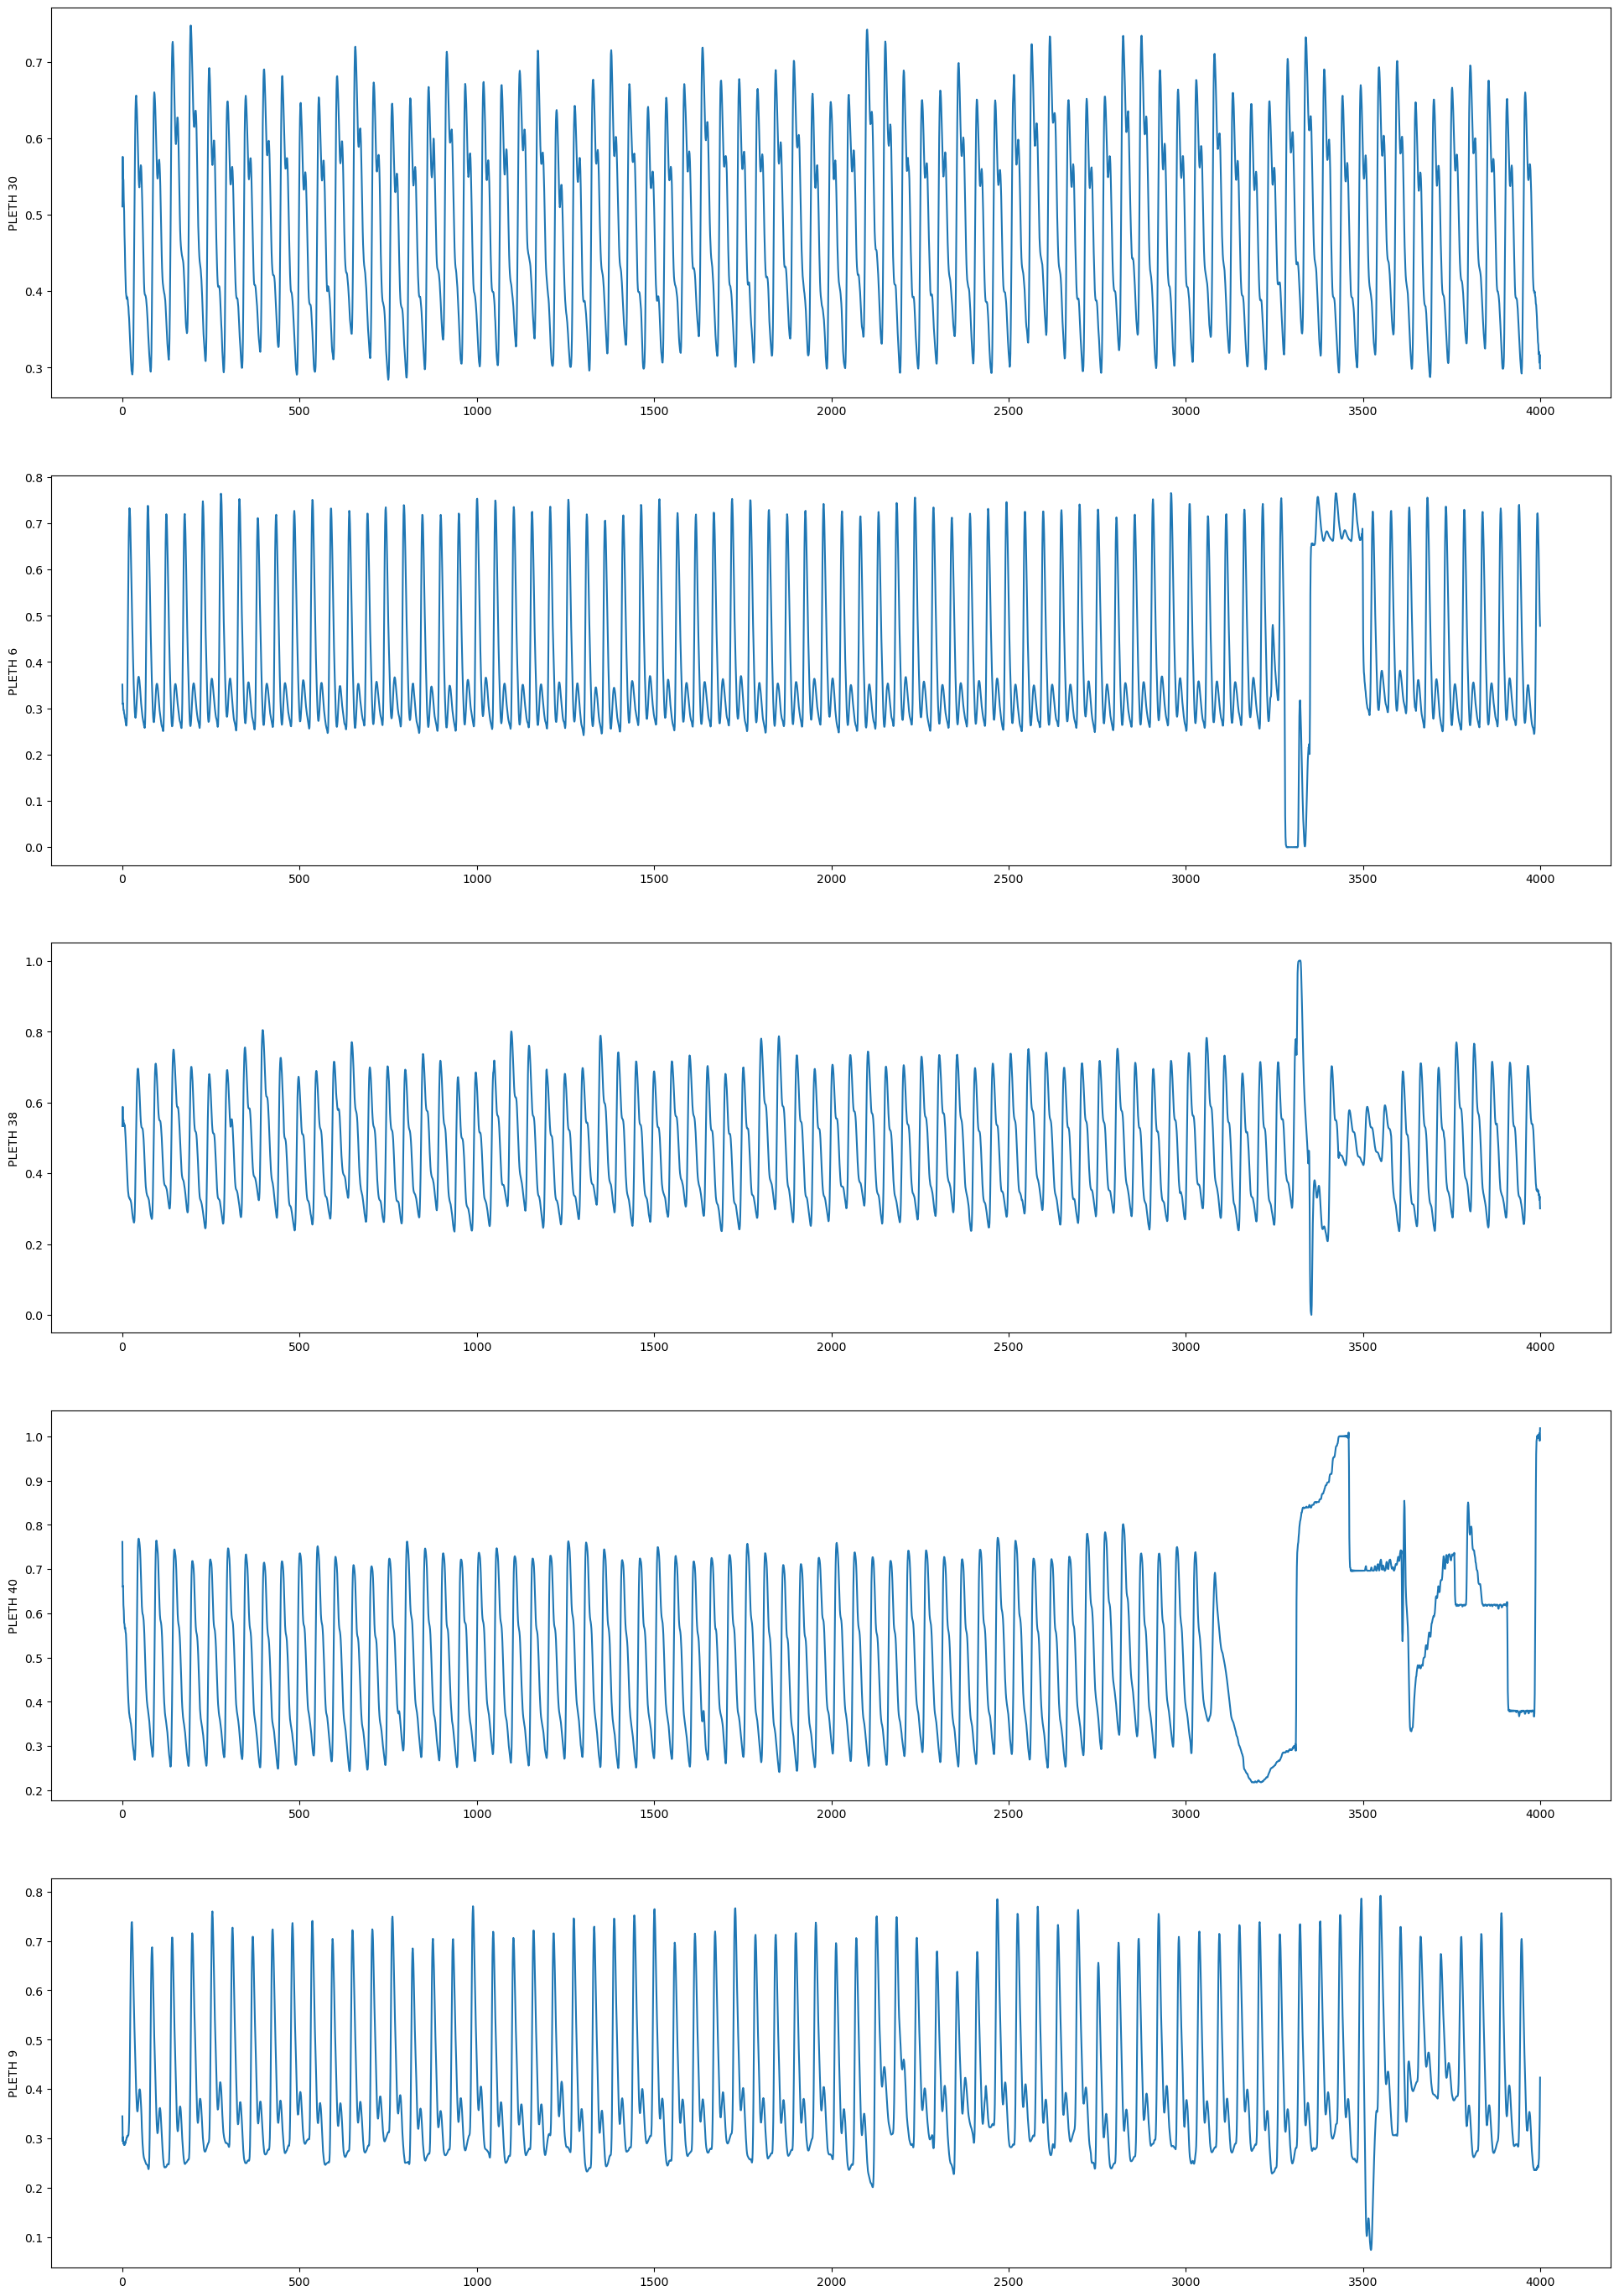

In [22]:
import random as rd
randomID=[]                        

for i in range(5):
    a = rd.randrange(0,len(data['PLETH']))       
    while a in randomID:              
        a = rd.randint(0,len(data['PLETH']))
    randomID.append(a) 

plt.figure(figsize=(24,35))

for i in range(5):
    # plt.subplot(10,1,2*i+1)
    # plt.plot(data['ART'][randomID[i]])
    # plt.ylabel('ART'+ str(randomID[i]))

    plt.subplot(5,1,i+1)
    plt.plot(data['PLETH'][randomID[i]])
    plt.ylabel('PLETH '+ str(randomID[i]))

plt.show()

Below is the code to check the results  
It doesn't matter if you don't run it

(54, 4000)
{'result': 1, 'reason': '첫번째 peak가 너무 늦게 검출되거나, 마지막 peak가 너무 이르게 검출됌'}
{'result': 1, 'reason': 'peak간격의 std가 14 초과'}


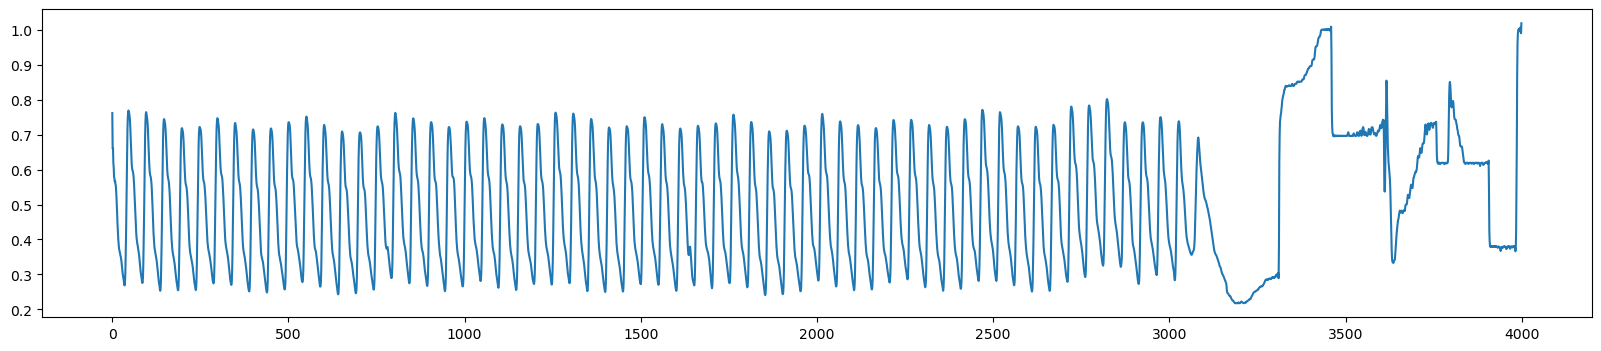

In [27]:
dataID = 40
data = np.load(output_dir + 'valSet'+str(s)+'.npz', allow_pickle=True)
print(data['PLETH'].shape)

print(check_ppg_abnormal(data['PLETH'][dataID][2500:3250], sig_length=750, fs=100))
print(check_ppg_abnormal(data['PLETH'][dataID][3250:], sig_length=750, fs=100))

plt.figure(figsize=(20,4))
plt.plot(data['PLETH'][dataID])
plt.show()

std_peak_dist_PPG: 55.948637159451884
std_peaks_PPG: 0.1261384078098361
max_min_differ_pks: 0.3714244862707876
max_differ_pks: 0.2194535116718599
std_valley_dist_PPG: 48.60335085450091
std_valley_PPG: 0.2461701855699531
max_min_differ_val: 0.8856536286565007
max_differ_val: 0.6183762783387844


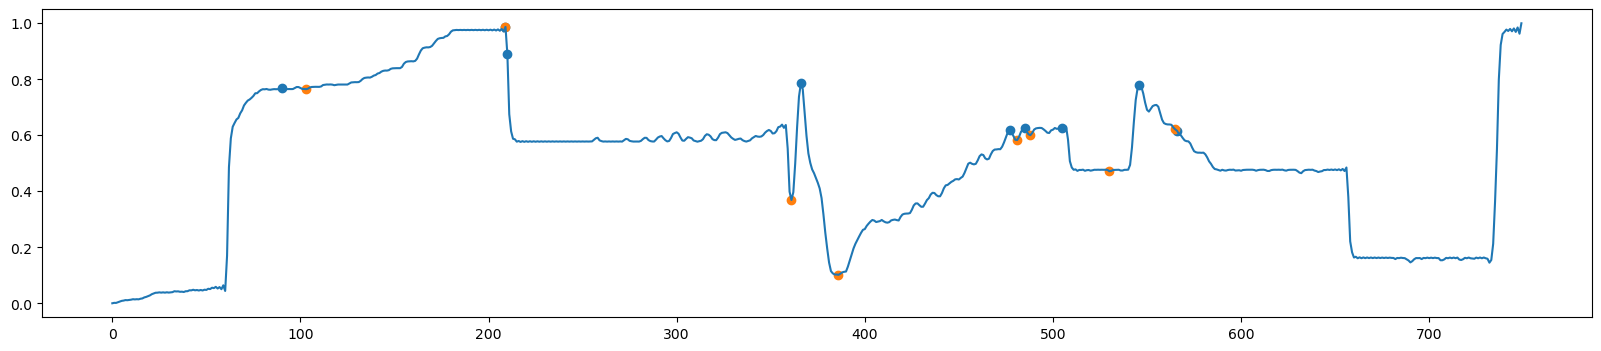

In [30]:
dataID = 40

d1 = data['PLETH'][dataID][2500:3250]
d2 = data['PLETH'][dataID][3250:]

PPG = d2
PPG = minmax_scale(PPG)
sig_length = len(PPG)
# Transpose the Signals if they are in column format, necessary for peak detection
if PPG.shape[0] > 1:
    PPG = PPG.T

try:
    wd_p, _ = hp.process(PPG, sample_rate=100) # peak 검출
except Exception:
    print('heartpy error')

# Peak
pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
pks_PPG = np.array(pks_PPG)

if pks_PPG[-1] == (sig_length-1):
    pks_PPG = np.delete(pks_PPG,-1)

P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])  # peak의 위치 리스트

if all(np.gradient(PPG[-3:])>=0):
    val_PPG = np.concatenate([val_PPG, [np.argmin(PPG[pks_PPG[-1]:len(PPG)])+pks_PPG[-1]]], axis=-1)



peak_dist_PPG = get_difference_list(pks_PPG) # peak 간격 리스트
std_peak_dist_PPG = np.std(peak_dist_PPG) # peak 간격의 std, feature 1
std_peaks_PPG = np.std(PPG[pks_PPG]) # peak 값의 std, feature 2
max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # 최대 peak와 최소 peak 차이, feature 4
differ_pks = get_difference_list(PPG[pks_PPG])
max_differ_pks = max(np.abs(differ_pks)) # peak간 차분값의 최댓값, feature 5

print('std_peak_dist_PPG:',std_peak_dist_PPG) # 10
print('std_peaks_PPG:',std_peaks_PPG) # 0.1
print('max_min_differ_pks:',max_min_differ_pks) # 0.3
print('max_differ_pks:',max_differ_pks) # 0.2


valley_dist_PPG = get_difference_list(val_PPG) # valley 간격 리스트
std_valley_dist_PPG = np.std(valley_dist_PPG) # valley 간격의 std
std_valley_PPG = np.std(PPG[val_PPG]) # valley 값의 std
num_valley_PPG = len(val_PPG) # valley 갯수
max_min_differ_val = np.max(PPG[val_PPG]) - np.min(PPG[val_PPG]) # 최대 valley와 최소 valley 차이, feature 4
differ_val = get_difference_list(PPG[val_PPG])
max_differ_val = max(np.abs(differ_val)) # valley간 차분값의 최댓값, feature 5



print('std_valley_dist_PPG:',std_valley_dist_PPG) # 10
print('std_valley_PPG:',std_valley_PPG) # 0.1
print('max_min_differ_val:',max_min_differ_val) # 0.3
print('max_differ_val:',max_differ_val) # 0.2


plt.figure(figsize=(20,4))
plt.plot(PPG)
plt.scatter(pks_PPG, PPG[pks_PPG])
plt.scatter(val_PPG, PPG[val_PPG])
plt.show()